# 0. Imports, configs y checks

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # un poco menos de warnings de tensorflow
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async" # intento de liberar VRAM
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # deshabilitar la dGPU

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, VGG19, Xception, EfficientNetV2L

# pandas para el csv
import pandas as pd

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

E0000 00:00:1730956325.367718  156653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730956325.373228  156653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Ver si detecta la GPU en caso de haberla
gpus = tf.config.list_physical_devices("GPU")

if gpus:
 for gpu in gpus:
    print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Análisis exploratorio sobre el conjunto de datos

In [3]:
# lo vamos a estar usando seguido
CATEGORIES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./test')
VALIDATION_DIR = Path('./validation')
SIZE = 150

Creamos datasets para Keras:

In [4]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [5]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 5565 images belonging to 6 classes.
Found 7794 images belonging to 6 classes.


## Volumetría de los datos

El dataset de train y test cuenta con imágenes de escenas naturales de todo el mundo, train contiene 14034 imágenes y el dataset de test cuenta con 3000 imágenes, dando un total de 258 MB train y test juntos.
Las imagenes se dividiran en 6 categorias:

* "buildings": imagenes de edificios
* "forest": imagenes de bosques en diferentes estaciones y ambientes
* "glacier": imagenes de paisajes nevados
* "mountain": imagenes de montañas en distintos ambientes
* "sea": imagenes sobre oceanos y playas
* "street": imagenes de paisaje urbano

In [ ]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CATEGORIES[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
sample_images(train)

Luego de revisar brevemente las carpetas, observamos que existen varias imagenes que difieren de las categorias, y decidimos eliminarlas del dataset de train, puesto que estas imagenes pueden tener un impacto negativo a la hora de entrenar

In [ ]:
#mostrar imagen del dino
tf.keras.utils.load_img("./train/glacier/1512.jpg")

aaah yes... a glacier...

Por ultimo, decidimos dividir la carpeta de train para crear una carpeta de validation, mediante el uso de un script externo "trainValidationSplit.sh"

In [ ]:
sample_images(validation)

## Estructura y tipo de las imágenes

Las imagenes:
* tienen una dimension de 150x150
* todas son del tipo "jpg"

## Distribución de la variable a predecir

Primero contamos con una carpeta "train" que contiene carpetas por cada  categoria de imagen

In [ ]:
root_path = "./train"

contents = os.listdir(root_path)

# Loop through each item in the list
for item in contents:
    # Check if the item is a directory
    if os.path.isdir(os.path.join(root_path, item)):
        print("Found directory:", item)

Vemos la cantidad de imagenes que existe en la carpeta train

In [ ]:
num_images = 0
for dirpath, dirnames, filenames in os.walk(root_path):
    # Count the number of image files in the current subdirectory
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            num_images += 1

    # Print the number of image files in the current subdirectory
    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0

In [ ]:
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()

Podemos ver que existe un balance entre clases, con poca diferencia entre las mismas, lo que favorece al entrenamiento.

# 2. Modelado

Recursos consultados:
* https://keras.io/api/applications/
* https://keras.io/api/applications/xception/
* https://keras.io/api/layers/activation_layers/
* https://keras.io/guides/transfer_learning/

### Funciones y variables

In [6]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

In [7]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [8]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=-1)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=-1)),
)

def show_confusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)
    
        batch_images, batch_labels = next(dataset)
        
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        predictions = np.argmax(model.predict(batch_images), axis=-1)
        labels = np.argmax(batch_labels, axis=-1)
        
        print('Accuracy:', accuracy_score(labels, predictions))
    
        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))
            
        plt.xticks([0, 1, 2, 3, 4, 5], CATEGORIES, rotation=45)
        plt.yticks([0, 1, 2, 3, 4, 5], CATEGORIES)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')
    
        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )
    
        plt.show()

Found 5565 images belonging to 6 classes.
Found 7794 images belonging to 6 classes.


In [9]:
def compile_summarize(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',],
    )
    model.summary()

In [10]:
def accuracy_over_epochs(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [11]:
def fit_model(model, n_epochs=5):
    return model.fit(
        train,
        epochs=n_epochs,
        batch_size=128,
        validation_data=validation,
        callbacks=[OurCustomCallback()]
    )

In [12]:
# no parecería andar
# gc.collect() y del (modelo) tampoco
# con suerte la env var de la primer celda hace algo por el lado de CUDA
# https://github.com/tensorflow/tensorflow/issues/48545
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-2276233833
def clear_vram():
    tf.keras.backend.clear_session(free_memory=True)

### Entrenamientos

#### MLP Simple

In [13]:
clear_vram()
model_mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730953705.666266  143324 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730953705.668015  143324 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1871 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [14]:
compile_summarize(model_mlp)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    33,750,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,753,506 (128.76 MB)

 Trainable params: 33,753,506 (128.76 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_mlp = fit_model(model_mlp)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1730953707.327783  143635 service.cc:148] XLA service 0x7f07640049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730953707.327820  143635 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730953707.456401  143635 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/174 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.1319 - loss: 5.7156

I0000 00:00:1730953708.486119  143635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.1675 - loss: 4.1262 - val_accuracy: 0.3054 - val_loss: 1.8120
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 285ms/step - accuracy: 0.1798 - loss: 2.0016 - val_accuracy: 0.1771 - val_loss: 1.7896
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 277ms/step - accuracy: 0.1939 - loss: 1.9451 - val_accuracy: 0.2966 - val_loss: 1.7476
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - accuracy: 0.2152 - loss: 1.8813 - val_accuracy: 0.2892 - val_loss: 1.7343
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 283ms/step - accuracy: 0.2128 - loss: 1.8697 - val_accuracy: 0.1619 - val_loss: 1.7219


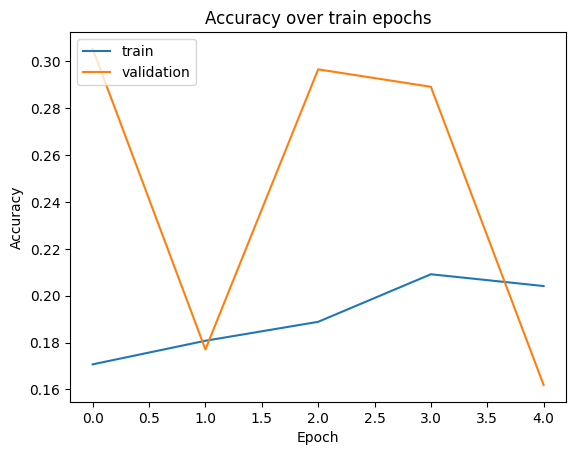

In [16]:
accuracy_over_epochs(history_mlp)

In [17]:
model_mlp.set_weights(model_weights_at_epochs[2])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.29996405463695186


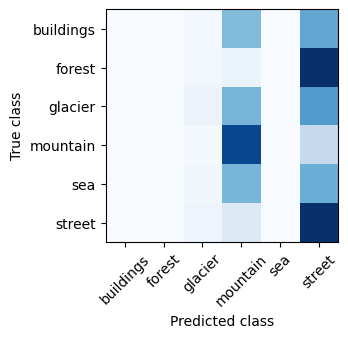

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.29564994225587066


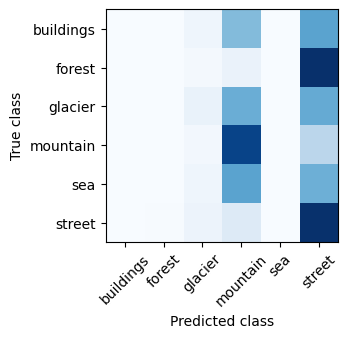

In [18]:
show_confusion_matrix(model_mlp)

#### Convolucional

In [13]:
clear_vram()
model_convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730954188.942810  145591 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730954188.943822  145591 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1830 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [14]:
compile_summarize(model_convolutional)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 10)   │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 147, 147, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 144, 144, 10)   │         1,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 144, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,296,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,806 (4.95 MB)

 Trainable params: 1,298,806 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_convolutional = fit_model(model_convolutional)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1730954190.719980  145814 service.cc:148] XLA service 0x7fac7000afa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730954190.720017  145814 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730954190.880638  145814 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/174 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.2865 - loss: 2.7540

I0000 00:00:1730954194.091232  145814 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.3725 - loss: 2.1623 - val_accuracy: 0.6041 - val_loss: 1.0593
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - accuracy: 0.6101 - loss: 0.9839 - val_accuracy: 0.6597 - val_loss: 0.9223
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 279ms/step - accuracy: 0.6836 - loss: 0.8388 - val_accuracy: 0.6636 - val_loss: 0.8643
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 279ms/step - accuracy: 0.7219 - loss: 0.7319 - val_accuracy: 0.6912 - val_loss: 0.7866
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 285ms/step - accuracy: 0.7485 - loss: 0.6579 - val_accuracy: 0.6754 - val_loss: 0.8468


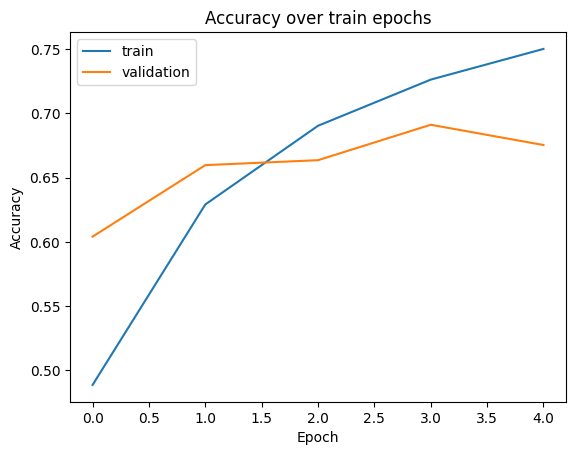

In [16]:
accuracy_over_epochs(history_convolutional)

In [17]:
model_convolutional.set_weights(model_weights_at_epochs[3])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy: 0.7262760603882099


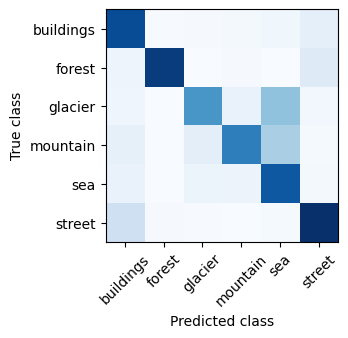

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.6936994738868215


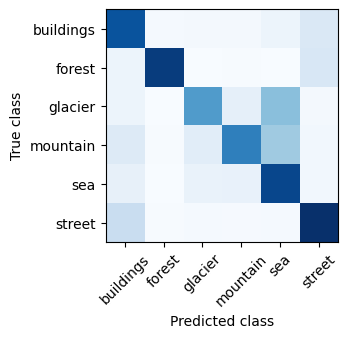

In [18]:
show_confusion_matrix(model_convolutional)

#### VGG16

In [14]:
clear_vram()
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [15]:
compile_summarize(model_vgg16)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       819,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,544,694 (59.30 MB)

 Trainable params: 830,006 (3.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
history_vgg16 = fit_model(model_vgg16)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1730955470.101910  151331 service.cc:148] XLA service 0x7f7cd400ef80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730955470.101944  151331 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730955470.315750  151331 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730955476.308214  151331 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.6990 - loss: 0.8372 - val_accuracy: 0.8499 - val_loss: 0.3913
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step - accuracy: 0.8640 - loss: 0.3588 - val_accuracy: 0.8489 - val_loss: 0.3982
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.8853 - loss: 0.3266 - val_accuracy: 0.8622 - val_loss: 0.3631
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - accuracy: 0.8907 - loss: 0.2933 - val_accuracy: 0.8693 - val_loss: 0.3545
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - accuracy: 0.8991 - loss: 0.2794 - val_accuracy: 0.8463 - val_loss: 0.4080


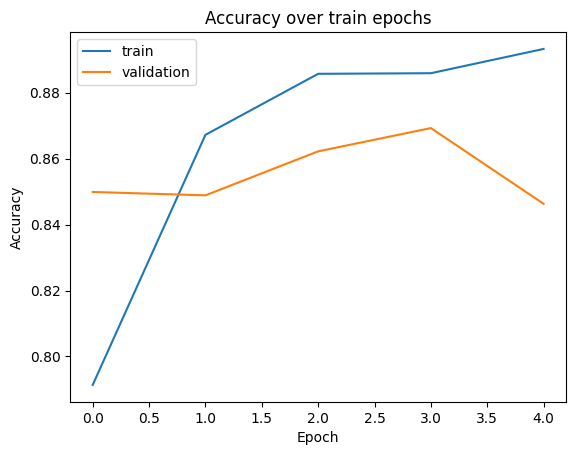

In [17]:
accuracy_over_epochs(history_vgg16)

In [18]:
model_vgg16.set_weights(model_weights_at_epochs[3])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step
Accuracy: 0.9063623292595255


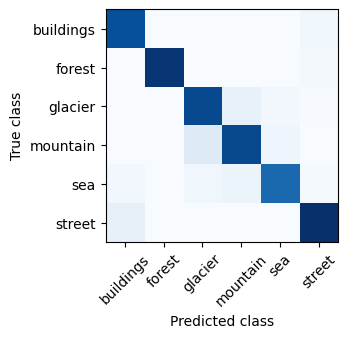

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step
Accuracy: 0.8671885025022456


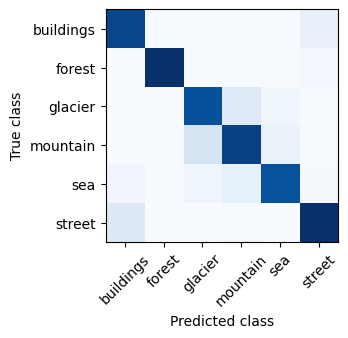

In [19]:
show_confusion_matrix(model_vgg16)

#### VGG16 - LeakyReLU

In [13]:
clear_vram()
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16_leaky = Sequential([
    pretrained_model,

    Flatten(),
    
    Dense(256),
    LeakyReLU(negative_slope=0.1),  
    
    Dropout(0.25),
    
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    
    Dropout(0.25),
    
    Dense(100),
    LeakyReLU(negative_slope=0.1),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730955912.105060  154848 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730955912.106514  154848 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1973 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [14]:
compile_summarize(model_vgg16_leaky)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,858,498 (64.31 MB)

 Trainable params: 2,143,810 (8.18 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
history_vgg16_leaky = fit_model(model_vgg16_leaky)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1730955914.443872  155104 service.cc:148] XLA service 0x7f0a20010f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730955914.443907  155104 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730955914.698899  155104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730955920.830500  155104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 67s 340ms/step - accuracy: 0.6237 - loss: 0.9593 - val_accuracy: 0.8422 - val_loss: 0.4144
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step - accuracy: 0.8272 - loss: 0.4661 - val_accuracy: 0.8285 - val_loss: 0.4482
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 291ms/step - accuracy: 0.8449 - loss: 0.4118 - val_accuracy: 0.8413 - val_loss: 0.4286
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.8632 - loss: 0.3653 - val_accuracy: 0.8698 - val_loss: 0.3402
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 291ms/step - accuracy: 0.8712 - loss: 0.3442 - val_accuracy: 0.8648 - val_loss: 0.3589


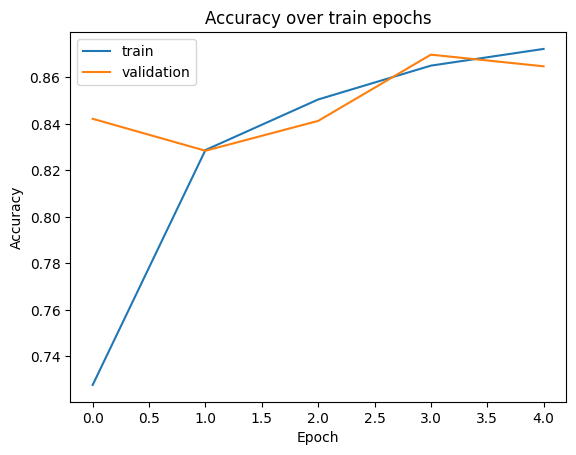

In [16]:
accuracy_over_epochs(history_vgg16_leaky)

In [17]:
model_vgg16_leaky.set_weights(model_weights_at_epochs[3])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step
Accuracy: 0.903666427030913


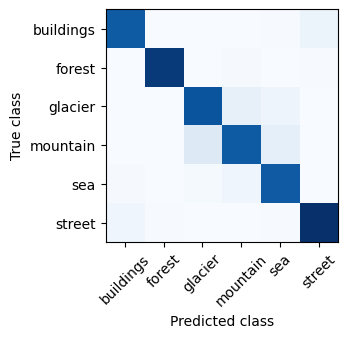

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step
Accuracy: 0.8706531502630566


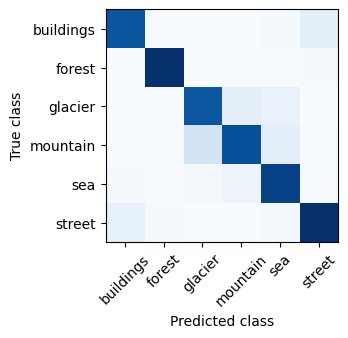

In [18]:
show_confusion_matrix(model_vgg16_leaky)

#### Xception

In [13]:
clear_vram()
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
pretrained_model.trainable = False

model_xception = Sequential([
    pretrained_model,

    Flatten(),
    
    Dense(256),
    LeakyReLU(negative_slope=0.1),
    
    Dropout(0.25),
    
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    
    Dropout(0.15),
    
    Dense(64),
    LeakyReLU(negative_slope=0.05),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730952740.123264  138492 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730952740.124424  138492 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1858 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [14]:
compile_summarize(model_xception)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,010,478 (129.74 MB)

 Trainable params: 13,148,998 (50.16 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [15]:
history_xception = fit_model(model_xception, 15)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1730952744.752454  139592 service.cc:148] XLA service 0x7fd344005960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730952744.752483  139592 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730952745.421894  139592 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/174 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.2031 - loss: 2.3085

I0000 00:00:1730952749.808853  139592 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 67s 338ms/step - accuracy: 0.7363 - loss: 1.1197 - val_accuracy: 0.8698 - val_loss: 0.3542
Epoch 2/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 299ms/step - accuracy: 0.8716 - loss: 0.3888 - val_accuracy: 0.8711 - val_loss: 0.3628
Epoch 3/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step - accuracy: 0.8879 - loss: 0.3306 - val_accuracy: 0.8900 - val_loss: 0.2951
Epoch 4/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.8927 - loss: 0.3131 - val_accuracy: 0.8853 - val_loss: 0.3008
Epoch 5/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 299ms/step - accuracy: 0.9004 - loss: 0.2855 - val_accuracy: 0.8894 - val_loss: 0.2969
Epoch 6/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 297ms/step - accuracy: 0.9085 - loss: 0.2526 - val_accuracy: 0.9054 - val_loss: 0.2613
Epoch 7/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.9112 - loss: 0.2328 - val_accuracy: 0.9011 - val_loss: 0.2797
Epoch 8/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.9084 - loss: 0.2532 - val

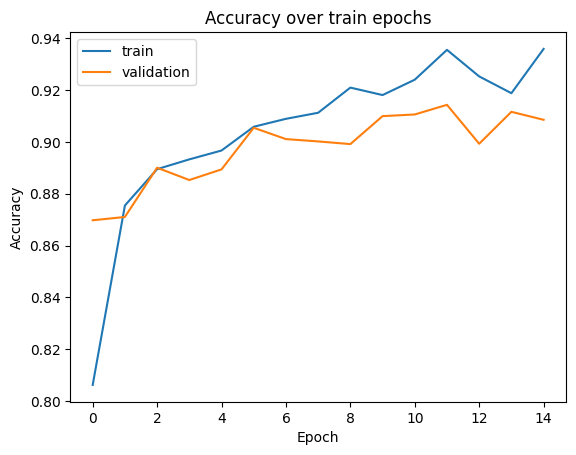

In [16]:
accuracy_over_epochs(history_xception)

In [17]:
model_xception.set_weights(model_weights_at_epochs[11])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step
Accuracy: 0.9494967649173257


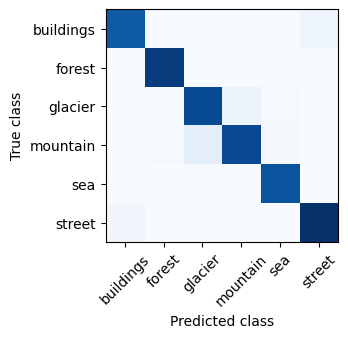

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step
Accuracy: 0.9151802900038496


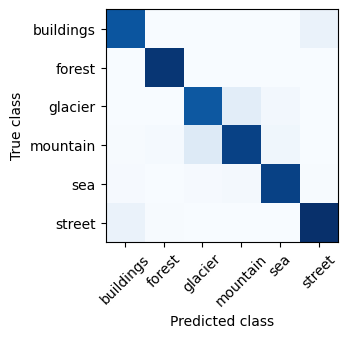

In [18]:
show_confusion_matrix(model_xception)

#### EfficientNetV2L

In [13]:
clear_vram()
pretrained_model = EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling="max",
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-l",
)

pretrained_model.trainable = False


model_env2l = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730956341.040604  156653 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730956341.042061  156653 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1992 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [14]:
compile_summarize(model_env2l)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       128,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,885,654 (449.70 MB)

 Trainable params: 138,806 (542.21 KB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [15]:
history_env2l = fit_model(model_env2l)

/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1730956373.679830  156861 service.cc:148] XLA service 0x7f724000d100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730956373.679852  156861 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1730956378.774394  156861 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730956410.361413  156861 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 185s 702ms/step - accuracy: 0.1854 - loss: 2.2770 - val_accuracy: 0.1660 - val_loss: 1.8170
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 67s 387ms/step - accuracy: 0.2388 - loss: 1.7718 - val_accuracy: 0.2347 - val_loss: 1.7110
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 63s 360ms/step - accuracy: 0.2423 - loss: 1.7444 - val_accuracy: 0.2948 - val_loss: 1.6700
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 64s 368ms/step - accuracy: 0.2460 - loss: 1.7398 - val_accuracy: 0.2721 - val_loss: 1.6844
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 65s 375ms/step - accuracy: 0.2588 - loss: 1.7234 - val_accuracy: 0.1845 - val_loss: 1.7908


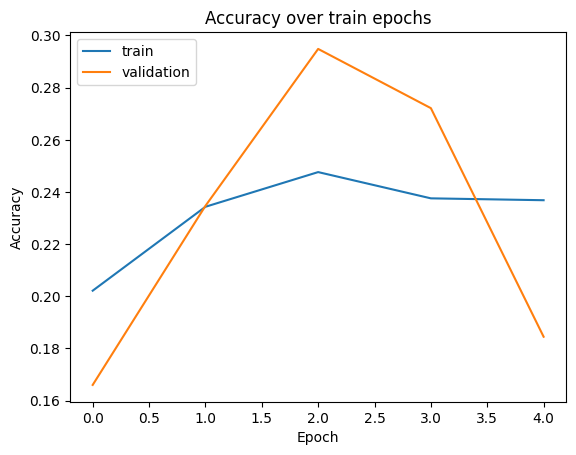

In [16]:
accuracy_over_epochs(history_env2l)

In [17]:
model_env2l.set_weights(model_weights_at_epochs[2])

######################### train #########################
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step
Accuracy: 0.2875629043853343


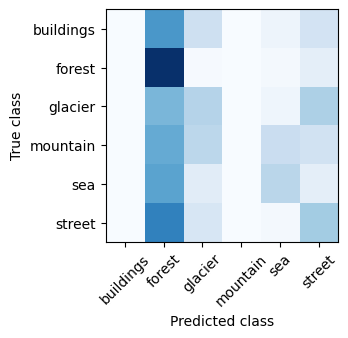

######################### validation #########################
244/244 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step
Accuracy: 0.2966765045553702


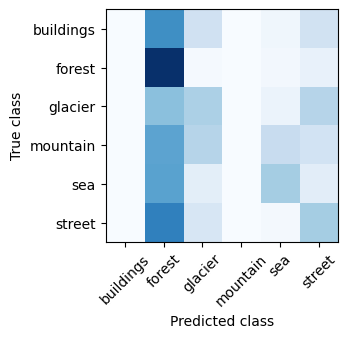

In [18]:
show_confusion_matrix(model_env2l)

# 3. Conclusiones

# 4. Competencia

Creación de archivos CSV para la submission

In [ ]:
CSV_FILENAME = "ConvolutionalXceptionLeaky-2"
MODEL = model_xception

images = []
labels = []

for image in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image)
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    images.append(image_array)

inputs = np.array(images) / 255.0

predictions = MODEL.predict(inputs)

for i, filename in enumerate(os.listdir(TEST_DIR)):
    predicted_label = CATEGORIES[np.argmax(predictions[i])]
    labels.append([filename, predicted_label])

df = pd.DataFrame(labels, columns=["ID", "Label"])
df.to_csv("./submissions/"+CSV_FILENAME+".csv", index=False)
print("CSV exported successfully.")